<a href="https://colab.research.google.com/github/tanish36/Tensorflow-Projects/blob/master/UD_multi_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demand Prediction

This guide will show you how to use Multivariate (many features) Time Series data to predict future demand of bike shares<br>

DATA SOURCE https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

## Importing the Library

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing

## What we are trying to achieve ??

We have count of new bike share with their timestamp and along with the weather condition and season with this information we will be able to see in which conditions people will be able to take bikes for riding and predict the demand of the bikes for the future dates

## Data

the feature in the data
1. timestamp - timestamp field for grouping the data
2. cnt - the count of a new bike shares
2. t1 - real temperature in C
2. t2 - temperature in C “feels like”
2. hum - humidity in percentage
2. wind_speed - wind speed in km/h
2. weather_code - category of the weather
2. is_holiday - boolean field - 1 holiday / 0 non holiday
2. is_weekend - boolean field - 1 if the day is weekend
2. season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

In [0]:
url = 'https://raw.githubusercontent.com/tanish36/Tensorflow-Projects/master/london_merged.csv'

In [0]:
df = pd.read_csv(url,parse_dates=['timestamp'], index_col="timestamp")

In [0]:
df.shape


(17414, 9)

In [0]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## Coint Johansen Test for Stationarity

For time series modeling, data needs to be **stationary** — meaning if there is a trend in the data you need to get rid of it.A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.

 For a series to be stationary, the eigenvalues should be less than 1 in modulus

In [0]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp = df
coint_johansen(johan_test_temp,-1,1).eig

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


array([2.61219379e-01, 1.31970167e-01, 5.22046139e-02, 4.19830465e-02,
       2.10126207e-02, 1.75450605e-02, 1.36518877e-02, 6.26085775e-04,
       7.56291478e-05])

## Exploration
Let’s start simple. Let’s have a look at the bike shares over time:

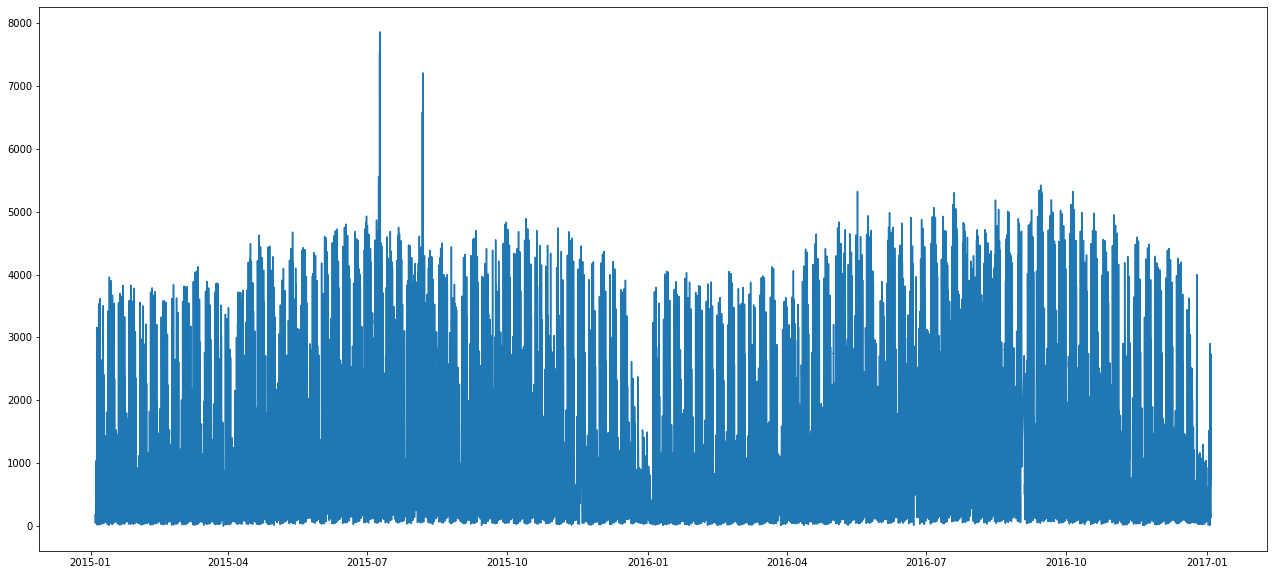

In [0]:
plt.figure(figsize=(22,10))
plt.plot(df.index, df["cnt"]);

Let’s have a look at the same data on a monthly basis
Our data seems to have a strong seasonality component. Summer months have more demand

In [0]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

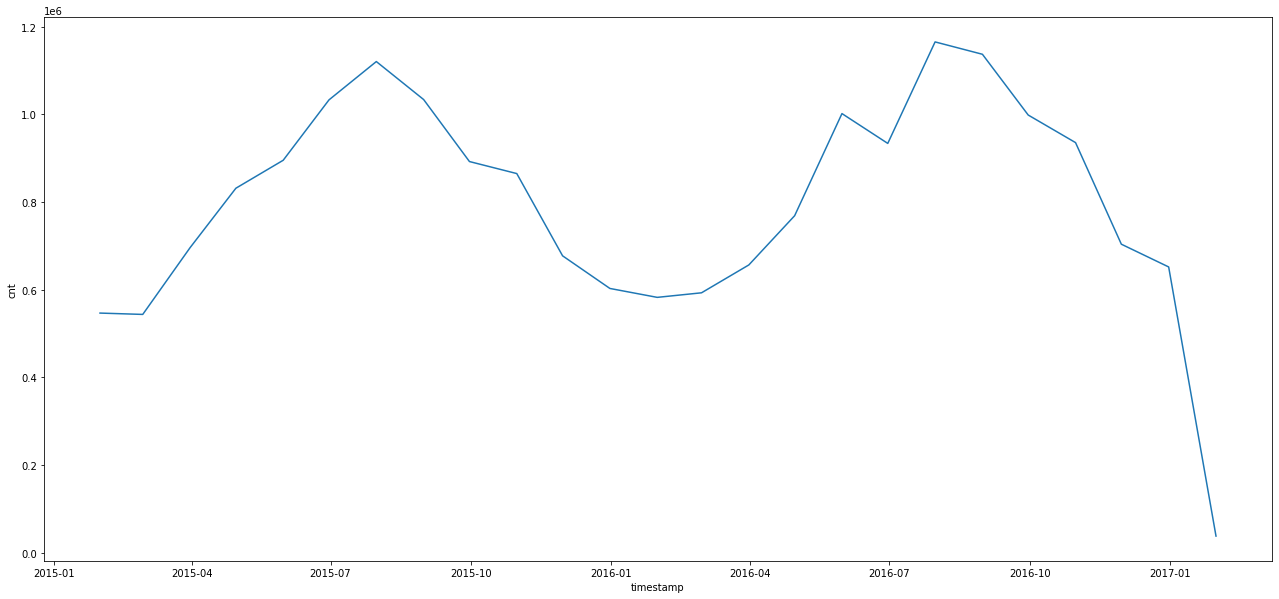

In [0]:
import seaborn as sns
df_by_month = df.resample('M').sum()
plt.figure(figsize=(22,10))

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

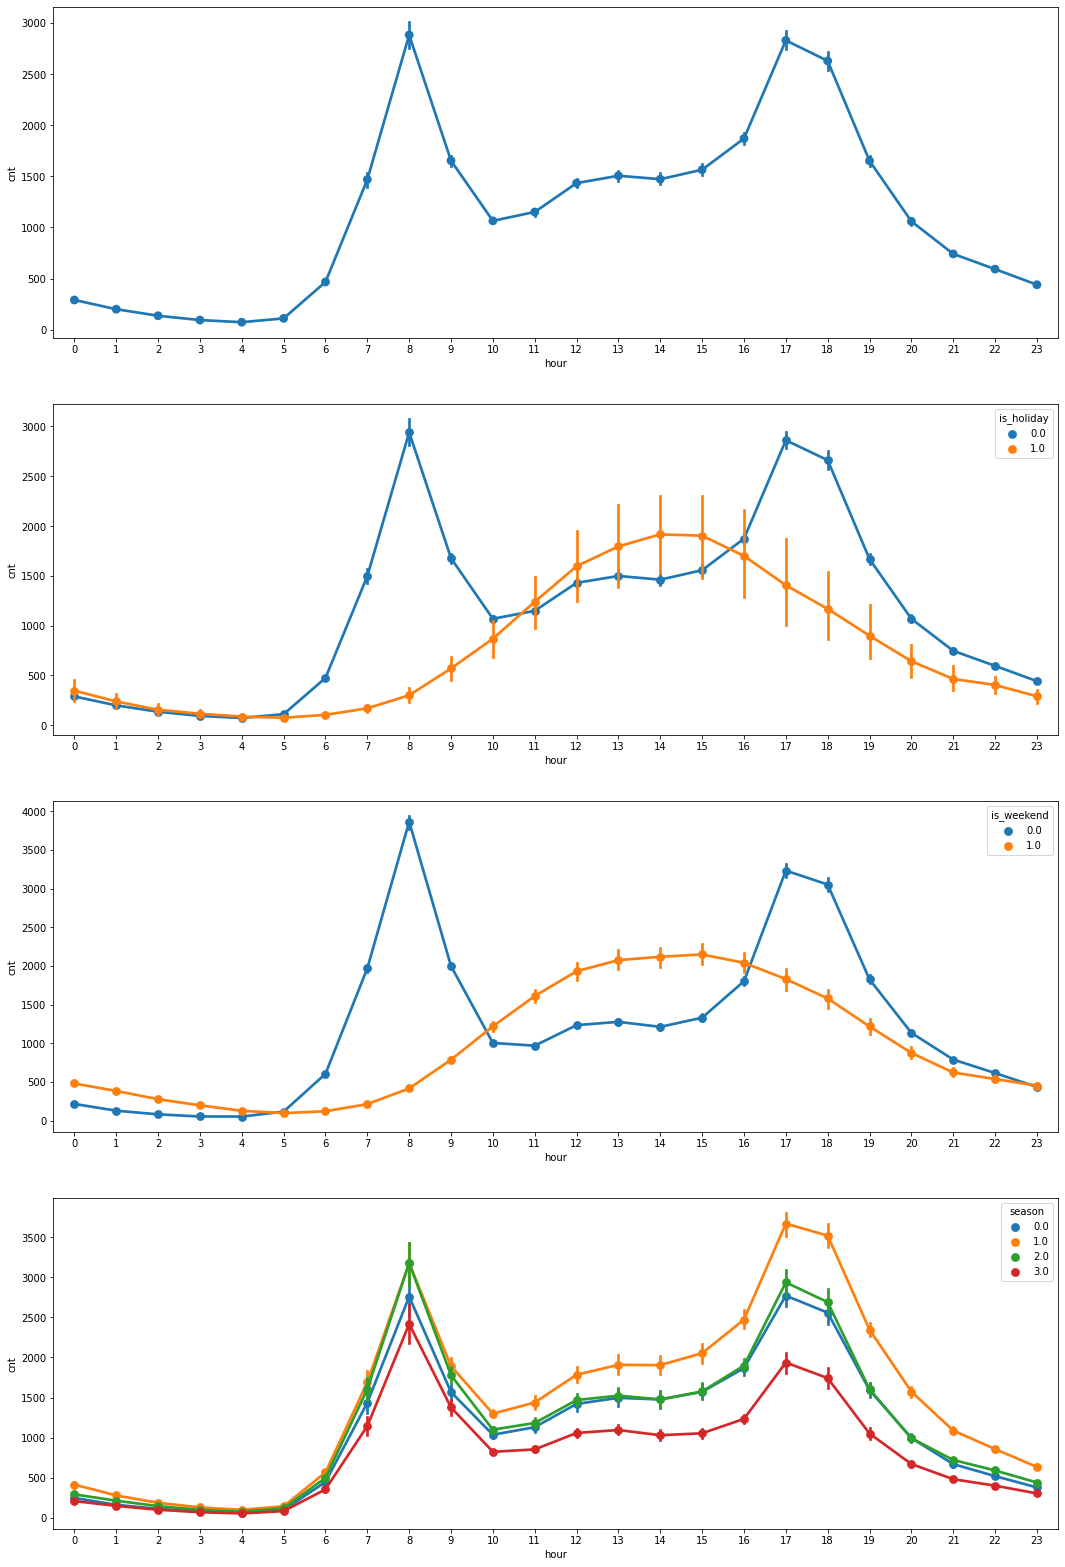

In [0]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

## Preprocessing data

In [0]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['t1'] = scaler.fit_transform(df['t1'].values.reshape(-1,1))
df['t2'] = scaler.fit_transform(df['t2'].values.reshape(-1,1))
df['hum'] = scaler.fit_transform(df['hum'].values.reshape(-1,1))
df['wind_speed'] = scaler.fit_transform(df['wind_speed'].values.reshape(-1,1))
df['cnt'] = scaler.fit_transform(df['cnt'].values.reshape(-1,1))

We’ll use the last 10% of the data for testing

In [0]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


To prepare the sequences, we’re going to reuse the same create_dataset() function:

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Each sequence is going to contain 10 data points from the history:

In [0]:
time_steps = 10

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [0]:
batch_size  = 256
buffer_size = 1000

train_data = tf.data.Dataset.from_tensor_slices((X_train , y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()


test_data = tf.data.Dataset.from_tensor_slices((X_test , y_test))
test_data = test_data.batch(batch_size).repeat() 

In [0]:
print(X_test.shape, y_train.shape)

(1732, 10, 13) (15662,)


Making the lstm Model

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Fitting the Model on the dataset

In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 25

history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,validation_data = test_data,validation_steps = 50)

Epoch 1/25
200/200 [==============================] - 2s 8ms/step - loss: 0.1427 - val_loss: 0.0767
Epoch 2/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0807 - val_loss: 0.0727
Epoch 3/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0708 - val_loss: 0.0637
Epoch 4/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0656 - val_loss: 0.0623
Epoch 5/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0603 - val_loss: 0.0598
Epoch 6/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0562 - val_loss: 0.0556
Epoch 7/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0530 - val_loss: 0.0537
Epoch 8/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0499 - val_loss: 0.0508
Epoch 9/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0474 - val_loss: 0.0484
Epoch 10/25
200/200 [==============================] - 1s 6ms/step - loss: 0.0449 - val_loss: 0.0445

Plotting the losses

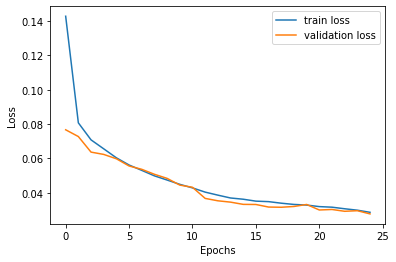

In [0]:

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Predicting on future dates

In [0]:
X_test,y_test = create_dataset(df,df.cnt,10)
y_pred = simple_lstm_model.predict(X_test)

Plotting the graph

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

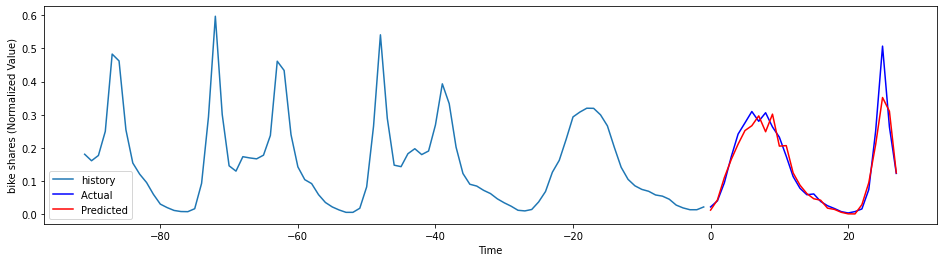

In [0]:
plt.figure(figsize=(16,4))
num_in = create_time_steps(91)
num_out = 28
plt.plot(num_in,y_train[15571:],label='history')
plt.plot(np.arange(num_out),y_test[15661:15689], 'b',label='Actual ')
plt.plot(np.arange(num_out),y_pred[15661:15689], 'r',label='Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

In [0]:
X_test[-1:].shape

(1, 10, 13)

In [0]:
X_test[-1]

array([[ 0.11170483,  0.21126761,  0.2       ,  0.63522013,  0.40707965,
         4.        ,  0.        ,  0.        ,  3.        , 13.        ,
         3.        ,  1.        ,  1.        ],
       [ 0.09732824,  0.21126761,  0.2       ,  0.66666667,  0.38938053,
         3.        ,  0.        ,  0.        ,  3.        , 14.        ,
         3.        ,  1.        ,  1.        ],
       [ 0.10750636,  0.21126761,  0.2       ,  0.63522013,  0.47787611,
         4.        ,  0.        ,  0.        ,  3.        , 15.        ,
         3.        ,  1.        ,  1.        ],
       [ 0.15279898,  0.21126761,  0.2       ,  0.63522013,  0.46017699,
         4.        ,  0.        ,  0.        ,  3.        , 16.        ,
         3.        ,  1.        ,  1.        ],
       [ 0.34885496,  0.21126761,  0.2       ,  0.66666667,  0.37168142,
         3.        ,  0.        ,  0.        ,  3.        , 17.        ,
         3.        ,  1.        ,  1.        ],
       [ 0.28244275,  0.183098

## Predicting the single date in future

In [0]:
y_pred = simple_lstm_model.predict(X_test[-1:])

In [0]:
y_pred

array([[0.01935525]], dtype=float32)

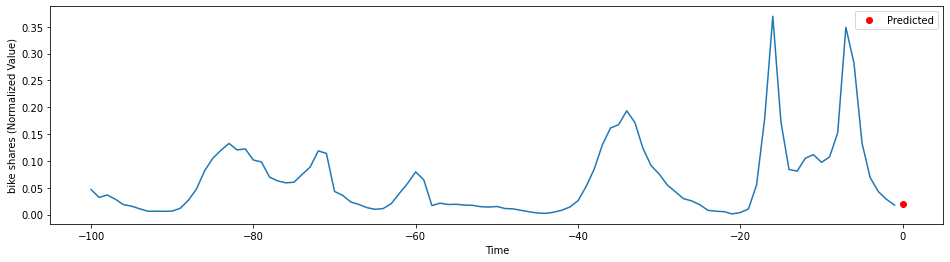

In [0]:
plt.figure(figsize=(16,4))
num_in = create_time_steps(100)
num_out = 1
plt.plot(num_in,y_test[-100:])
plt.plot(np.arange(num_out),y_pred, 'ro',label='Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()

In [0]:
df.tail()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2017-01-03 19:00:00,0.132570,0.183099,0.1750,0.761006,0.336283,3.0,0.0,0.0,3.0,19,3,1,1
2017-01-03 20:00:00,0.068830,0.183099,0.1750,0.761006,0.371681,4.0,0.0,0.0,3.0,20,3,1,1
2017-01-03 21:00:00,0.042875,0.197183,0.1875,0.729560,0.424779,4.0,0.0,0.0,3.0,21,3,1,1
2017-01-03 22:00:00,0.028499,0.197183,0.1875,0.698113,0.407080,4.0,0.0,0.0,3.0,22,3,1,1
2017-01-03 23:00:00,0.017684,0.183099,0.1750,0.698113,0.389381,2.0,0.0,0.0,3.0,23,3,1,1


## Predicting on the range of dates

So we are going to predict the future bike share demand for some future time but before that we need the features of the last 10 entries from the end of the dataframe and then copy the feature column of the 2016 for maintaining the seasonality in the data and append both the frames into one

In [0]:
df1 =  df['2016-01-03 00:00:00':'2016-01-06 23:00:00']

In [0]:
df2 = df['2017-01-03 14:00:00':'2017-01-03 23:00:00']

In [0]:
df_future = df2.append(df1, sort=False)

Let's make the cnt column as zero all after 10th entry

In [0]:
df_future['cnt'][10:]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_future  = df_future.reset_index(drop=True)

In [0]:
df_future[:40]

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
0,0.097328,0.211268,0.2000,0.666667,0.389381,3.0,0.0,0.0,3.0,14,3,1,1
1,0.107506,0.211268,0.2000,0.635220,0.477876,4.0,0.0,0.0,3.0,15,3,1,1
2,0.152799,0.211268,0.2000,0.635220,0.460177,4.0,0.0,0.0,3.0,16,3,1,1
3,0.348855,0.211268,0.2000,0.666667,0.371681,3.0,0.0,0.0,3.0,17,3,1,1
4,0.282443,0.183099,0.1750,0.761006,0.389381,2.0,0.0,0.0,3.0,18,3,1,1
5,0.132570,0.183099,0.1750,0.761006,0.336283,3.0,0.0,0.0,3.0,19,3,1,1
6,0.068830,0.183099,0.1750,0.761006,0.371681,4.0,0.0,0.0,3.0,20,3,1,1
7,0.042875,0.197183,0.1875,0.729560,0.424779,4.0,0.0,0.0,3.0,21,3,1,1
8,0.028499,0.197183,0.1875,0.698113,0.407080,4.0,0.0,0.0,3.0,22,3,1,1
9,0.017684,0.183099,0.1750,0.698113,0.389381,2.0,0.0,0.0,3.0,23,3,1,1


This will make the prediction and change the value in the dataframe and again repeat the same process

In [0]:
predictions = []

In [0]:
for i in range(50):
  X_f, y_f = create_dataset(df_future, df_future.cnt, time_steps)
  y_pred = simple_lstm_model.predict(X_f[i:i+1])
  df_future['cnt'][i+10]=y_pred
  predictions.append(float(y_pred[0][0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
predictions

[0.011087941937148571,
 0.02091258391737938,
 0.019313707947731018,
 0.010254688560962677,
 0.00039952248334884644,
 -0.005755830556154251,
 -0.0025106631219387054,
 0.013111419044435024,
 0.037085942924022675,
 0.06578937917947769,
 0.09158113598823547,
 0.10992041230201721,
 0.1118209958076477,
 0.10604459792375565,
 0.097102589905262,
 0.08699021488428116,
 0.07539145648479462,
 0.06299181282520294,
 0.053178004920482635,
 0.047046221792697906,
 0.04321865364909172,
 0.038720063865184784,
 0.0355338491499424,
 0.029724616557359695,
 0.02711307816207409,
 0.023441968485713005,
 0.017695114016532898,
 0.012427632696926594,
 0.020180553197860718,
 0.05893435329198837,
 0.11878417432308197,
 0.17325283586978912,
 0.19435001909732819,
 0.17859145998954773,
 0.1584351360797882,
 0.15218758583068848,
 0.15876173973083496,
 0.16168220341205597,
 0.15773829817771912,
 0.15368203818798065,
 0.1499735563993454,
 0.142143115401268,
 0.12732374668121338,
 0.10875854641199112,
 0.0889512151479721

### Plotting of the graph

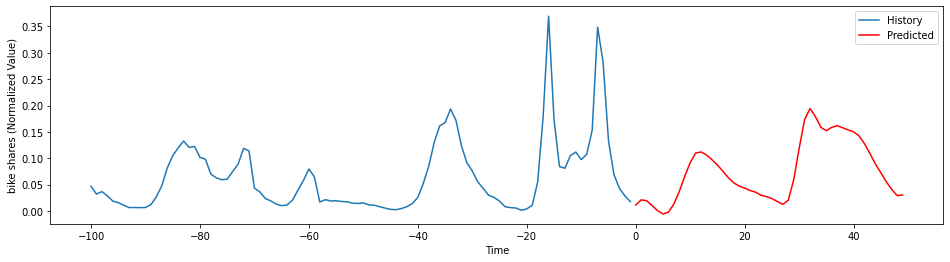

In [0]:
plt.figure(figsize=(16,4))
num_in = create_time_steps(100)
num_out = 50
plt.plot(num_in,y_test[-100:],label='History')
plt.plot(np.arange(num_out),predictions, 'r',label='Predicted')
plt.xlabel("Time")
plt.ylabel("bike shares (Normalized Value)")
plt.legend()
plt.show()